# Updated version 

In [1]:
import numpy as np
import pylab as plt
from sklearn.neighbors import KDTree
import scipy.linalg as scplinag
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Import the data as txt files and then cut them off so we only work with a subset 
dataset = r"C:\Users\noemi\Noemi\UCL Master 2017 2018\Dissertation\CODE\DATA\IQ Mulus\Cassette_idclass\Cassette_GT.txt"
data_whole = np.loadtxt(dataset, delimiter=",", skiprows= 2)

In [21]:
# Only use a subset of the whole dataset to speed up testing 
data = data_whole[0:100]

In [22]:
# Define all the columns we have
# As we cut it off at 100: all these arrays are 1D arrays with the shape: (100) (really it would be (1,100))
x = data[:,0]
y = data[:,1]
z = data[:,2]
inst_id = data[:,3]
obj_class = data[:,4]
# If we want to access one element, we just write: x[0]

# This is the dataset but only with the coordinates (3D)
dataxyz = data[:,0:3]

In [23]:
def calcCovarianceMatrix(data):
    """
    Function to compute the covariance matrix.
    
    Input: Dataset of 3D points; i.e. array of dimension: #points x 3 
    Output: 3x3 covariance matrix (np.array)
    """
    # Create covariance matrix and array to store the mean values for x_mean, y_mean, z_mean
    C = np.zeros((data.shape[1], data.shape[1]))
    mean_xyz = []
    # Calculate all mean values
    for i in range(0, dataxyz.shape[1]):
        mean_xyz.append(dataxyz[:,i].mean())
    mean_xyz = np.array(mean_xyz)
    # Check whether dimensions agree 
    if dataxyz[:,0].size != dataxyz[:,1].size or dataxyz[:,0].size != dataxyz[:,2].size:
        print "X, Y and Z must be of same dimensions."
    else:
        # For each row in covariance matrix C
        for i in range(0, C.shape[0]):
            # For each column in covariance matrix C
            for j in range(0, C.shape[1]):
                C[i,j] = 0
                # For each point in the dataset, access x, y, z-values
                for point in dataxyz:
                    # For each point, access x,y and z in all combinations (xx, xy, xz, yx, yy, yz etc)
                    C[i][j] = C[i][j] + (point[i]-mean_xyz[i])*(point[j]-mean_xyz[j])
    # Divide by the total number of points                
    C = (1.0/dataxyz.shape[0]) * C
    return C 

In [24]:
# Get eight parameters for each point

def calcFeatureDescr(covarianceMatrix):
    """
    Function to compute the 8 feature descriptors for each point.
    
    Input: 3x3 Covariance matrix of a point and its neighbourhood 
    
    Output: Array with feature descriptors as described by Weinmann et al. (1D array with 8 elements)
    
    """
    D, V = scplinag.eigh(C)
    # We sort the array with eigenvalues by size (from smallest to largest value)
    D.sort()
    # Get eigenvectors
    e1 = V[2] # eigenvector in direction of largest variance
    e2 = V[1] # second eigenvector, perpend. to e1
    e3 = V[0]
    # Find the eigenvalues
    evalue1 = D[2] # largest
    evalue2 = D[1]
    evalue3 = D[0] # smallest

    # Linearity
    lambda1 = (evalue1 - evalue2) / evalue1
    # Planarity
    lambda2 = (evalue2 - evalue3) / evalue1
    # Scattering
    lambda3 = evalue3 / evalue1
    # Omnivariance
    lambda4 = pow(evalue1*evalue2*evalue3, 1/3.0)
    # Anisotropy
    lambda5 = (evalue1 - evalue3) / evalue1
    # Eigentropy
    s = 0
    for elem in D:
        s = s + (elem*np.log(elem))
    lambda6 = (-1)*s  
    # Sum of eigenvalues
    lambda7 = sum(D)
    # Change of curvature
    lambda8 = evalue3/sum(D) 
    
    featureDescriptor = np.array([lambda1, lambda2, lambda3, lambda4, lambda5, lambda6, lambda7, lambda8])
    return featureDescriptor

In [25]:
def dominantDim(feature_descriptor, dataset_xyz, particular_point):
    """
    Function to determine
    
    Input:  Feature descriptor (as computed above, F: calcFeatureDescr) with dimensions: (1, 8) 
            Original dataset used to compute the covariance matrix and feature desc, only with x,y,z coordinates
    
    Output: Matrix identical to dataset_xyz but one column added; i.e. dominant class (#points x 4)
            0: Linear
            1: Planar
            2: Scattered (Volumetric)
    """
    # Get index of highest value
    domDim = np.argmax(feature_descriptor)
    if domDim == 0:
        #print "Linear feature"
        pass
    elif domDim == 1:
        print "Planar feature"
    else: 
        print "Volumetric feature"

    row_with_additional_col = np.append(dataset_xyz[particular_point], domDim)
    
    return row_with_additional_col

In [26]:
# 1: Compute covariance matrix
C = calcCovarianceMatrix(dataxyz)
# 2: Compute the feature descriptor for that point in the neighbourhood 
feat = calcFeatureDescr(C)
# 3: Only look at first 3 features for now (Following Demantke)
feat_123 = feat[0:3]
# 4: Find dominant dimension (i.e. linear, planar, scattered)
# The zero I just add for testing, in reality: add only to row 
additionalCol = dominantDim(feat_123, dataxyz, 0)

In [27]:
# Create kd-tree
kdt = KDTree(dataxyz, leaf_size=30, metric='euclidean')
# Get list with indices, the first value is always the point itself
idx_list = kdt.query(dataxyz, k=10, return_distance=False)
store = []
for j in range(0, dataxyz.shape[0]):
    # Look at all points now
    neighbourhood = []
    for i in idx_list[j]:
        neighbourhood.append(dataxyz[i])
    neighbourhood = np.array(neighbourhood)
    # Everything we did before with dataset, we do now with the neighbourhood only
    C = calcCovarianceMatrix(neighbourhood)
    feat = calcFeatureDescr(C)
    feat_123 = feat[0:3]
    # Potentially change that later to include it in function
    additionalCol = dominantDim(feat_123, dataxyz, idx_list[j][0])
    store.append(additionalCol)
store = np.array(store)

In [28]:
# This is the output array, the original xyz coordinates but with a label 
print store.shape

(100L, 4L)


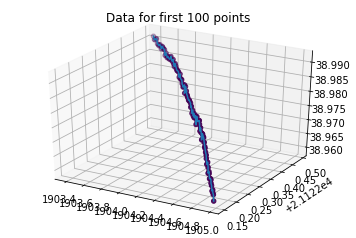

In [32]:
# Create array to colour code the points
label3D = store[:,3]
# Visualise the data 
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter3D(x,y,z,zdir='z', c=label3D)
ax.plot(x, y, z)
plt.title('Data for first '+ str(data.shape[0]) +' points')
plt.show()

In [33]:
np.savetxt('TestSave.txt', store, delimiter=' ', header='Test')